In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [ ]:
# Load Dataset
star_only_path = '/content/drive/MyDrive/StarOnly/test'
star_exoplanet_path = '/content/drive/MyDrive/StarAndExoplanet'

folders = {
    'star_only': star_only_path,
    'star_exoplanet': star_exoplanet_path
}

def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)


images = []
labels = []

for label_name, folder_path in folders.items():
    for img_file in os.listdir(folder_path):
        if img_file.endswith(('.png','.jpg','.jpeg')):
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128,128))
            img = preprocess_image(img)
            images.append(img)
            labels.append(label_name)

images = np.array(images, dtype=np.float32) / 255.0
labels = np.array(labels)

print("Dataset loaded:", images.shape, labels.shape)


Dataset loaded: (295, 128, 128, 3) (295,)


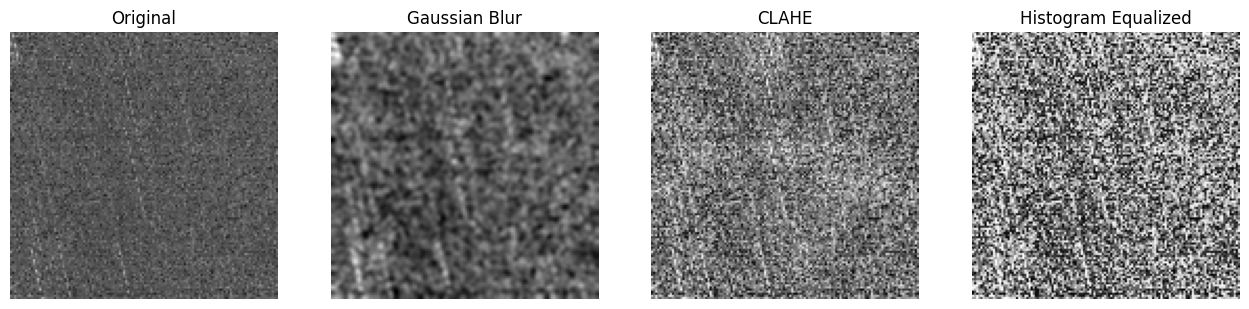

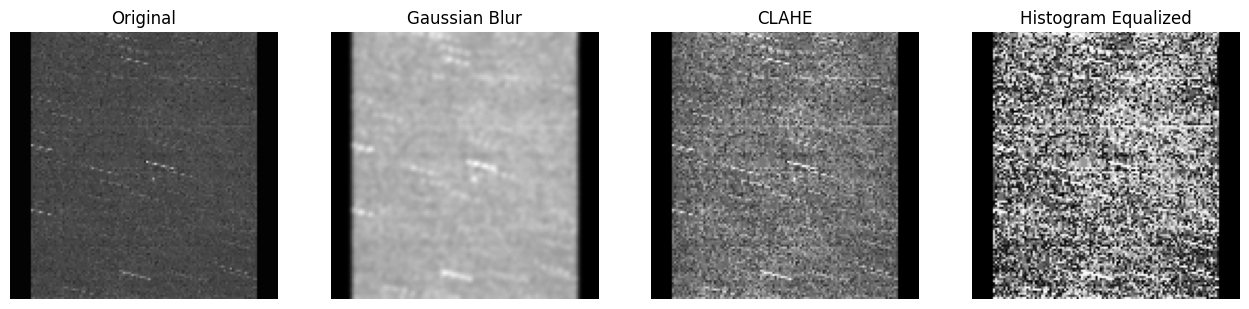

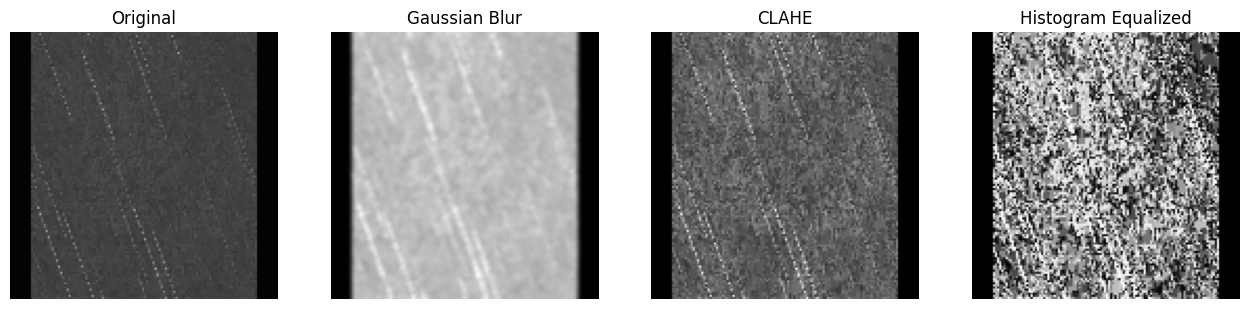

In [ ]:
# Display Sample Images
import numpy as np
import matplotlib.pyplot as plt
import cv2

def display_images(images, labels, n=3):

    star_indices = [i for i, label in enumerate(labels) if label == 'star_only']

    for _ in range(n):
        idx = np.random.choice(star_indices)
        img_original = (images[idx]*255).astype(np.uint8)

        #  Original
        img_orig_display = img_original.copy()

        #  Gaussian Blur
        img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
        img_blur = cv2.GaussianBlur(img_gray, (5,5), 0)

        #  Histogram Equalization
        img_hist = cv2.equalizeHist(img_gray)

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img_gray)


        # Plot all steps
        plt.figure(figsize=(20,4))

        plt.subplot(1,5,1)
        plt.imshow(img_orig_display)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1,5,2)
        plt.imshow(img_blur, cmap='gray')
        plt.title("Gaussian Blur")
        plt.axis('off')

        plt.subplot(1,5,3)
        plt.imshow(img_clahe, cmap='gray')
        plt.title("CLAHE")
        plt.axis('off')

        plt.subplot(1,5,4)
        plt.imshow(img_hist, cmap='gray')
        plt.title("Histogram Equalized")
        plt.axis('off')

        plt.show()

display_images(images, labels, n=3)


In [ ]:
#  Augmentation
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])

class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

dataset = AugmentedDataset(images, labels_encoded, transform=None)


In [ ]:
# 8️⃣ CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*32*32)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
# Training with K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
num_epochs = 15
batch_size = 16

for train_idx, val_idx in kf.split(images):
    print(f"Training Fold {fold_no}")

    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    # Apply transforms
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_transform

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = CNNModel(num_classes=len(le.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels_batch in train_loader:
            imgs, labels_batch = imgs.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    fold_no += 1


Training Fold 1
Epoch 1/15, Loss: 0.6408
Epoch 2/15, Loss: 0.4955
Epoch 3/15, Loss: 0.4767
Epoch 4/15, Loss: 0.4734
Epoch 5/15, Loss: 0.4758
Epoch 6/15, Loss: 0.4667
Epoch 7/15, Loss: 0.4663
Epoch 8/15, Loss: 0.4652
Epoch 9/15, Loss: 0.4637
Epoch 10/15, Loss: 0.4655
Epoch 11/15, Loss: 0.4640
Epoch 12/15, Loss: 0.4664
Epoch 13/15, Loss: 0.4621
Epoch 14/15, Loss: 0.4650
Epoch 15/15, Loss: 0.4633
Training Fold 2
Epoch 1/15, Loss: 0.6966
Epoch 2/15, Loss: 0.4648
Epoch 3/15, Loss: 0.4621
Epoch 4/15, Loss: 0.4537
Epoch 5/15, Loss: 0.4538
Epoch 6/15, Loss: 0.4526
Epoch 7/15, Loss: 0.4634
Epoch 8/15, Loss: 0.4438
Epoch 9/15, Loss: 0.4545
Epoch 10/15, Loss: 0.4532
Epoch 11/15, Loss: 0.4495
Epoch 12/15, Loss: 0.4511
Epoch 13/15, Loss: 0.4577
Epoch 14/15, Loss: 0.4541
Epoch 15/15, Loss: 0.4525
Training Fold 3
Epoch 1/15, Loss: 0.8402
Epoch 2/15, Loss: 0.4942
Epoch 3/15, Loss: 0.4859
Epoch 4/15, Loss: 0.4847
Epoch 5/15, Loss: 0.4979
Epoch 6/15, Loss: 0.4855
Epoch 7/15, Loss: 0.4814
Epoch 8/15, Los

In [ ]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

with torch.no_grad():
    for imgs, labels_batch in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels_batch.numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)


Accuracy: 0.6271186440677966
Precision: 0.8272013228606863
Recall: 0.6271186440677966
F1-score: 0.6247613481394896


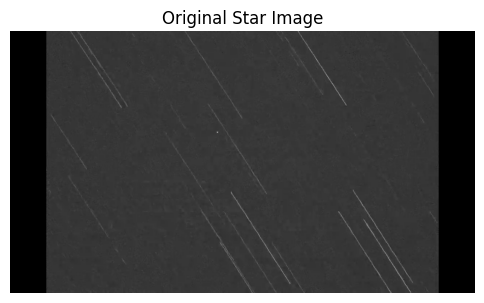

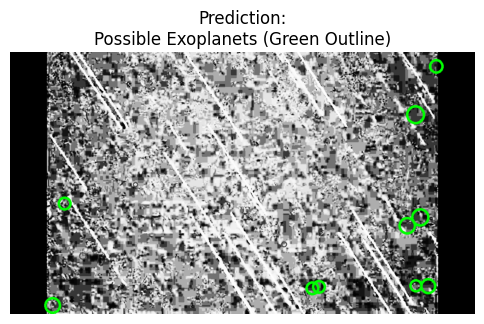

In [ ]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
val_transform = transforms.Compose([transforms.ToTensor()])

def detect_and_visualize_with_model(img_path, model, label_encoder, device):

    # Load image
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Display original image
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Star Image")
    plt.axis('off')
    plt.show()

    # Model preprocessing
    img_resized = cv2.resize(img, (128,128))
    input_tensor = val_transform(img_resized).unsqueeze(0).to(device)

    # Preprocessing for exoplanet detection
    proc_img = cv2.GaussianBlur(img_gray, (5,5), 0)
    proc_img = cv2.equalizeHist(proc_img)
    img_color = cv2.cvtColor(proc_img, cv2.COLOR_GRAY2BGR)
    h, w = proc_img.shape
    num_planets = random.randint(2, 5)
    for _ in range(num_planets):
        x = random.randint(10, w-10)
        y = random.randint(10, h-10)
        radius = random.randint(3, 7)
        cv2.circle(img_color, (x, y), radius + 3, (0, 0, 255), 2)  # thicker red outline
    proc_img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    # Model prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = torch.argmax(output, dim=1).cpu().item()
        label = label_encoder.inverse_transform([pred_class])[0]



    # Detect exoplanets (outlined circles)
    thresh = cv2.adaptiveThreshold(proc_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_img = cv2.cvtColor(proc_img, cv2.COLOR_GRAY2BGR)

    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        if 15 <= radius <= 25:  # exoplanet size range
            cv2.circle(final_img, (int(x), int(y)), int(radius), (0,255,0), 6)

    # Display processed image
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
    plt.title("Prediction:\nPossible Exoplanets (Green Outline)")
    plt.axis('off')
    plt.show()


img_path = "/content/drive/MyDrive/StarOnly/test/frame297_png.rf.20b275b435549170baaa46c3427f363c.jpg"
detect_and_visualize_with_model(img_path, model, le, device)

